# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

## Question 1

Import required packages

In [1]:
import requests
import pandas as pd

Set header for GET request to website

In [2]:
header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", "X-Requested-With": "XMLHttpRequest"}

Set website URL

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

Fetch the page

In [5]:
r = requests.get(url, headers=header)

Read all tables on page

In [6]:
dataframes = pd.read_html(r.text, header=0)

Isolate dataframe of interest

In [9]:
TO_df = dataframes[0]

Create dataframe that ignores "Not assigned" Boroughs

In [13]:
TO_df = TO_df[TO_df['Borough'] != 'Not assigned']
TO_df

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Print shape of dataframe

In [17]:
TO_df.shape

(103, 3)

---

## Question 2

Import required packages

In [21]:
import geocoder

Implement code from assignment instructions, and add loop to apply to all postal codes in dataframe

In [ ]:
latitudes = []
longitudes = []

for postal_code in TO_df['Postal Code']:
    
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        
    latitudes = [latitudes, lat_lng_coords[0]]
    longitudes = [longitudes, lat_lng_coords[1]]

Geocoder implementation does not seem to work  
Read csv data instead

In [24]:
geospatial_df = pd.read_csv('Geospatial_Coordinates.csv')

Combine location data with dataframe from question 1

In [29]:
TO_df = pd.merge(left=TO_df, right=geospatial_df)
TO_df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


---

## Question 3

Import required packages

In [45]:
import folium
import numpy as np

Inspect dataframe

In [32]:
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(TO_df['Latitude'], TO_df['Longitude'], TO_df['Borough'], TO_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Definre credentials to connect with Foursquare to find more information about areas

In [33]:
CLIENT_ID = 'C2JDBLFA3FXQVVANZLZOYJ53FWMN102JBJNQ5AEBHJKIYRZ2'# your Foursquare ID
CLIENT_SECRET = 'G4OZIG4OK0O0JQ1XKMOA5MGLHVI1HRDN20RQYUELDTRSGCZZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Your credentails:
CLIENT_ID: C2JDBLFA3FXQVVANZLZOYJ53FWMN102JBJNQ5AEBHJKIYRZ2
CLIENT_SECRET:G4OZIG4OK0O0JQ1XKMOA5MGLHVI1HRDN20RQYUELDTRSGCZZ


Define function to find nearby venues for a given location

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Apply function to all areas in Toronto dataframe

In [98]:
toronto_venues = getNearbyVenues(names=TO_df['Neighborhood'],
                                   latitudes=TO_df['Latitude'],
                                   longitudes=TO_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Check size of dataframe

In [99]:
print(toronto_venues.shape)
toronto_venues.head()

(1685, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Transform dataframe

In [100]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and mean of frequency of occurence

In [101]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Function to sort the venues in descending order.

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,College Auditorium,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Gym,Pub,Sandwich Place,Pharmacy,Coffee Shop,Diner,Discount Store,Distribution Center,Cuban Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Middle Eastern Restaurant,Diner,Bridal Shop,Restaurant,Deli / Bodega,Ice Cream Shop,Supermarket
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Restaurant,Juice Bar,Grocery Store,Butcher,Café,Sushi Restaurant,Pizza Place


---  
# Clustering

Determine optimum k for kmeans using silhouette method

In [104]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))
    

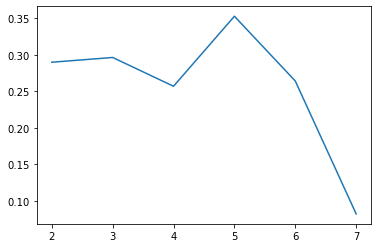

In [105]:
import matplotlib.pyplot as plt
k = [2,3,4,5,6,7]
plt.plot(k, sil)

Cluster neighborhoods

In [106]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


Create dataframe showing top venues and cluster

In [107]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = TO_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Construction & Landscaping,Food & Drink Shop,Curling Ice,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Coffee Shop,Hockey Arena,French Restaurant,Pizza Place,Portuguese Restaurant,Intersection,Dessert Shop,Dance Studio,Deli / Bodega,Department Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Park,Pub,Bakery,Café,Restaurant,Theater,Breakfast Spot,Yoga Studio,Event Space
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Coffee Shop,Event Space,Boutique,Furniture / Home Store,Miscellaneous Shop,Vietnamese Restaurant,Accessories Store,Comfort Food Restaurant,Donut Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Coffee Shop,Diner,Sushi Restaurant,College Auditorium,Park,Mexican Restaurant,Creperie,Café,Burrito Place,Hobby Shop


In [120]:
toronto_merged = toronto_merged.dropna()

Visualise clusters

In [121]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [122]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,York,0.0,Park,Women's Store,Pool,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store
64,York,0.0,Park,Cupcake Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
85,Scarborough,0.0,Park,Playground,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Distribution Center
91,Downtown Toronto,0.0,Park,Trail,Playground,Diner,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
98,Etobicoke,0.0,Park,River,Women's Store,Curling Ice,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [125]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,1.0,Fast Food Restaurant,Women's Store,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [126]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2.0,Park,Construction & Landscaping,Food & Drink Shop,Curling Ice,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
1,North York,2.0,Coffee Shop,Hockey Arena,French Restaurant,Pizza Place,Portuguese Restaurant,Intersection,Dessert Shop,Dance Studio,Deli / Bodega,Department Store
2,Downtown Toronto,2.0,Coffee Shop,Park,Pub,Bakery,Café,Restaurant,Theater,Breakfast Spot,Yoga Studio,Event Space
3,North York,2.0,Clothing Store,Coffee Shop,Event Space,Boutique,Furniture / Home Store,Miscellaneous Shop,Vietnamese Restaurant,Accessories Store,Comfort Food Restaurant,Donut Shop
4,Downtown Toronto,2.0,Coffee Shop,Diner,Sushi Restaurant,College Auditorium,Park,Mexican Restaurant,Creperie,Café,Burrito Place,Hobby Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Downtown Toronto,2.0,Café,Coffee Shop,Restaurant,American Restaurant,Gym,Hotel,Tea Room,Seafood Restaurant,Deli / Bodega,Concert Hall
99,Downtown Toronto,2.0,Restaurant,Coffee Shop,Yoga Studio,Gay Bar,Sushi Restaurant,Burger Joint,Japanese Restaurant,Men's Store,Indian Restaurant,Ice Cream Shop
100,East Toronto,2.0,Light Rail Station,Pizza Place,Brewery,Smoke Shop,Restaurant,Burrito Place,Recording Studio,Farmers Market,Fast Food Restaurant,Butcher
101,Etobicoke,2.0,Baseball Field,Construction & Landscaping,Women's Store,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


In [127]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Etobicoke,3.0,Golf Course,Curling Ice,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


In [128]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,North York,4.0,Pizza Place,Women's Store,Cupcake Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner
63,York,4.0,Pizza Place,Convenience Store,Women's Store,Curling Ice,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


---  
# Conclusion  
5 clusters of data were found  
These correspond to:
1) Areas that represent a large concentration of parks  
2) Areas with a lot of diversity in categories (i.e. a lot of entertainment and places to eat)
3) An area with a large concentration of fast food places  
4) An area with the largest concentration of golf courses in Toronto (1 golf course)
5) Areas that represent a large concentration of pizza places

